<span style='color:gray'> Author: Glicerio Vergara.</span>

*https://www.linkedin.com/in/glicerio-vergara*
___
# <span style='color:DarkBlue'> Data analysis on Food Matter Live news.</span>  
___
 
This is my proposed solution for optimizing the statying well inform of in your prefer industry. This project takes as an example the website Food Matter Live which is a news provider to understan the most resent relevant news in the industry of chemical engineer.
Although this approach is indutrial specific, it goes to show the extent in which data anylytics.
An example the program will show the top and bottom 5 new according to sentimental analysis.

In [36]:
# Import libraries

## for data handling
import pandas as pd
import numpy as np

## for Web scrapping 
import requests
import re
from dateutil import parser
from bs4 import BeautifulSoup 
## for time
from datetime import datetime
from datetime import date 
import time 

## For plotting
import seaborn as sns # For plotting
import matplotlib.pyplot as plt # For plotting

## for Text cleaning and mining
import re  # For regular expressions
import nltk  # For text functions
from afinn import Afinn  # For sentiment values
import string # revoming punctuation
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('wordnet')
string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

wn = nltk.WordNetLemmatizer()# Remove by Lemmatizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alinaprendes/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alinaprendes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
# Declare a function to scrap specific data
def get_record(count,cards):
    card=cards[count]
    href =card.a.get('href')
    headline =card.a.p.text
    datepublishcard =parser.parse(str(card.find('span',{'class':'tile__caption-date'}).text))
    #lead=(str(card.p.text).encode('ascii', 'ignore')).decode("utf-8")
    
    record = (datepublishcard,headline,href)
    return record

In [38]:
def Clean_HTML_data(text):
    # URL
    url = re.compile(r"https?://\S+|www\.\s+")
    text = url.sub(r"",text)
    # HTML
    html = re.compile(r'<.*?>')
    text = html.sub(r"",text)
    # /n
    text = text.replace('\n','')
    # Dencode
    text=(text.encode('ascii', 'ignore')).decode("utf-8")

    return text

In [39]:
def get_Newsboday(value):
    url=value
    response = requests.get(url)
    # Parse the HTML document from the source code using BeautifulSoup
    html = BeautifulSoup(response.text, 'html.parser')
    # Search for specific html code
    try:
            Author = html.find('div',{'class':'article-header__author-bottom'}).a.text
    except AttributeError:
            Author = np.nan
    Body=Clean_HTML_data(str(html.find('div',{'class':'article-main__wrapper free-content'})))
    return (Author,Body)

In [40]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

In [41]:
def plotScoredist(news):
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].boxplot(news.neg)
    axs[0, 0].set_title('Negative')
    axs[0, 0].get_xaxis().set_visible(False)

    axs[0, 1].boxplot(news.neu)
    axs[0, 1].set_title('Neutral')
    axs[0, 1].get_xaxis().set_visible(False)

    axs[1, 0].boxplot(news.neu)
    axs[1, 0].set_title('Positive')
    axs[1, 0].get_xaxis().set_visible(False)

    axs[1, 1].boxplot(news.compound)
    axs[1, 1].set_title('Compound')
    axs[1, 1].get_xaxis().set_visible(False)

    fig.tight_layout()


In [42]:
def plotNews(df,i):
    df.index = ['1', '2', '3']
    dfl = pd.DataFrame(df['Body_lemmatized'][i], columns=['words'])
    dfl['line'] = range(1, len(dfl) + 1)

    afinn_scorer = Afinn()

    dfl['score'] = dfl['words'].map(afinn_scorer.score).astype(int)
    dfl = dfl[dfl['score'] != 0]

    score_acc = dfl.groupby(dfl['line'] // 10)\
        .score.mean()\
        .to_frame('score')\
        .rename_axis('section')
        
    ax = score_acc.plot.line(legend=False, figsize=(12, 6), grid=True, alpha=0.5, color='gray')
    score_acc.rolling(5, min_periods=5).mean().plot.line(ax=ax, color='black')
    plt.xlabel('Section of 15 words')
    plt.ylabel('Mean Sentiment Score')
    plt.title('{}'.format(df['Headline'][i]), loc='left')
    plt.axhline(0, color='red')
    plt.xticks(rotation=0);

In [43]:
def plotNewsbar(df,i):
    df.index = ['1', '2', '3']
    fig, ax = plt.subplots(1,1)
    df.iloc[i,[6,7,8]].T.plot.bar(color="k", alpha=0.5)
    plt.ylabel('score')
    plt.title('{}'.format(df['Headline'][i]))

In [44]:
def FMLnews(datelimit):
    # set Url
    url = "https://foodmatterslive.com/discover/explore-all/"
    # Ask for permission
    response = requests.get(url)
    # Parse the HTML document from the source code using BeautifulSoup
    html = BeautifulSoup(response.text, 'html.parser')
    # Search for specific html code
    cards = html.find_all('div',{'class':'tile post'})

    news = []
    [news.append(get_record(count,cards)) for count, value in enumerate(cards)]

    # Extract all the information from the website by a loop 

    while True:
        try:
            url = html.find('div',{'listing__pagination container not-last-page'}).find('a',{'next page-numbers'}).get('href')
        except AttributeError:
            break
        # Set a time break
        time.sleep(1)
        # Ask for permission
        response = requests.get(url)
        # Parse the HTML document from the source code using BeautifulSoup
        html = BeautifulSoup(response.text, 'html.parser')
        # Search for specific html code
        cards = html.find_all('div',{'class':'tile post'})

        # Create and fill the information from the website page
        [news.append(get_record(count,cards)) for count, value in enumerate(cards)]
        #date limit format ("YYYY-MM-DD")
        
        datelimitchek=parser.parse(datelimit)
        datecheck=parser.parse(str(cards[0].find('span',{'class':'tile__caption-date'}).text))
        if datelimitchek >= datecheck:
            break
        else:
            continue

    news=pd.DataFrame(news,columns=['Datepublish','Headline','Link'])

    # Get the author and body of the news
    author_body = []
    [author_body.append(get_Newsboday(value)) for value in news['Link']]
    author_body=pd.DataFrame(author_body,columns=["Author","Body"])
    # Joing the Author and data from news
    news['Author']=author_body['Author']
    news['Body']=author_body['Body']

    # Lematizing
    news['Body_lemmatized'] = news['Body'].apply(lambda x: clean_text(x))

    # Sentiment Analysis scoring
    scores = pd.DataFrame(news['Body'].apply(sia.polarity_scores).tolist())
    news = news.join(scores, rsuffix='_right')
    news=news.sort_values('compound',ascending=False)
    news.reindex()

    # Plotting score distribution
    plotScoredist(news)

    # Plotting top and bottom results
    topnews=news.head(3)
    bottomnews=news.tail(3)

    [plotNewsbar(topnews,i) for i in range (3)]

    [plotNewsbar(bottomnews,i) for i in range (3)]

    [plotNews(topnews,i) for i in range (3)]

    [plotNews(bottomnews,i) for i in range (3)]



    news.to_excel("Results/FML_{}_export_{}.xlsx".format(datelimit,date.today().strftime("%d.%m.%Y"))) 
    
    return  news.head()


,Datepublish,Headline,Link,Author,Body,Body_lemmatized,neg,neu,pos,compound
0,2021-12-11,Innovations in the ever-expanding diabetic foo...,https://foodmatterslive.com/discover/article/i...,Fiona Holland,Diabetes is a growing global health crisis. A ...,"[diabetes, growing, global, health, crisis, re...",0.041,0.833,0.126,0.9997
9,2021-09-11,Start-up in focus: Amai Proteins,https://foodmatterslive.com/discover/article/s...,NaN,Amai Proteins is an Israeli start-up that prod...,"[amai, protein, israeli, startup, produce, sug...",0.032,0.821,0.146,0.9993
8,2021-09-11,Interview: Food Tech Matters Partner The Food ...,https://foodmatterslive.com/discover/article/i...,Stef Bottinelli,"Founded byAntonio Iannone in 2017, is an Ital...","[founded, byantonio, iannone, 2017, italian, c...",0.022,0.798,0.181,0.9991
17,2021-05-11,Green Jobs: Plant-Based Nutritionist,https://foodmatterslive.com/discover/article/g...,Fiona Holland,A plant-based nutritionist helps people follow...,"[plantbased, nutritionist, help, people, follo...",0.019,0.870,0.112,0.9990
26,2021-01-11,Slow Food Movement: changing the way we eat an...,https://foodmatterslive.com/discover/article/s...,Carol Wilson,"In the mid 1980s, food and wine writer Carlo P...","[mid, 1980s, food, wine, writer, carlo, petrin...",0.037,0.832,0.131,0.9989


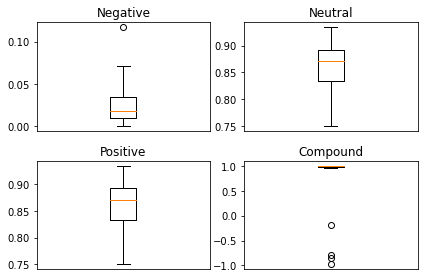

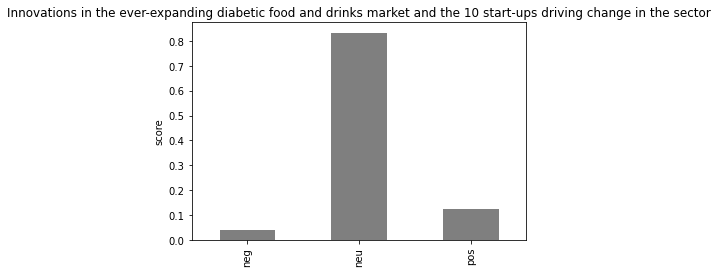

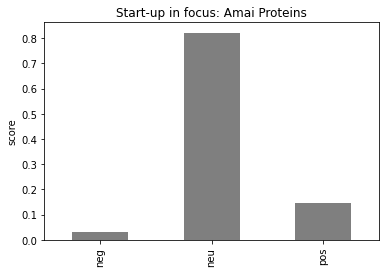

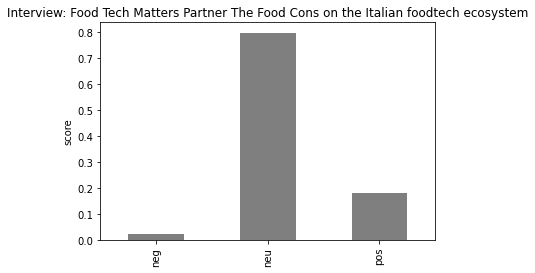

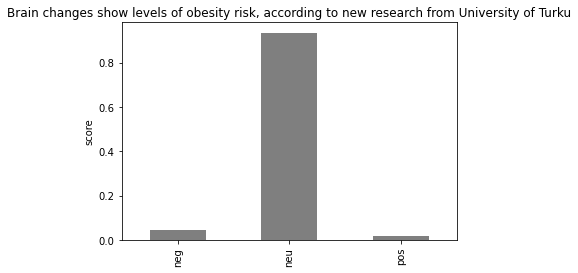

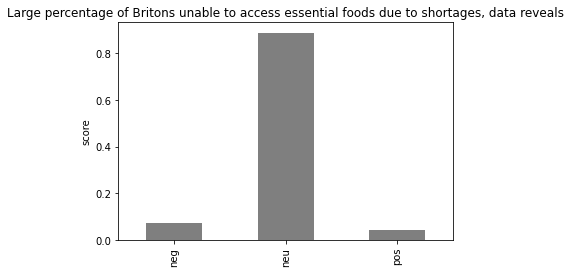

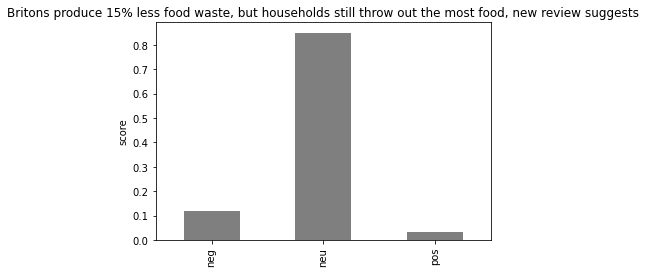

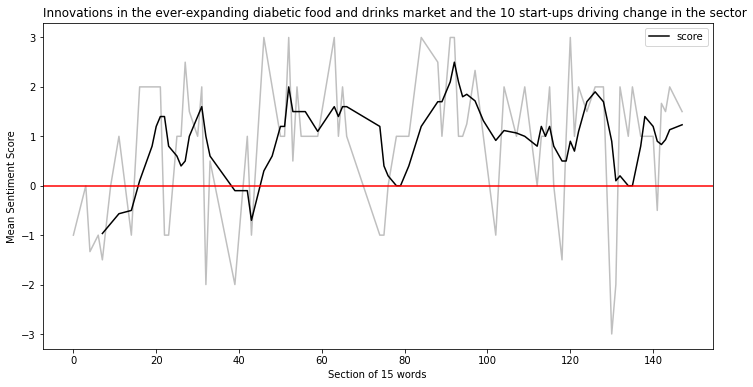

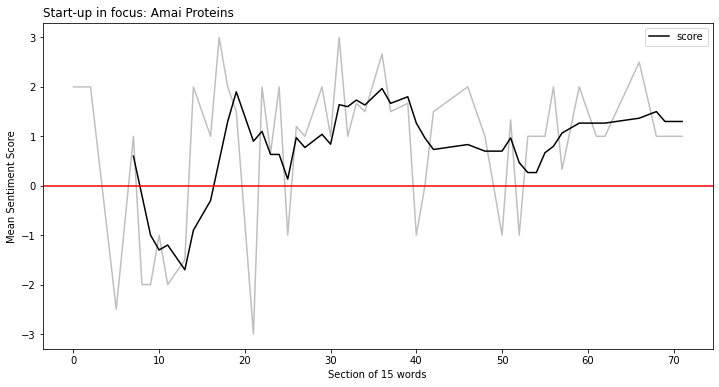

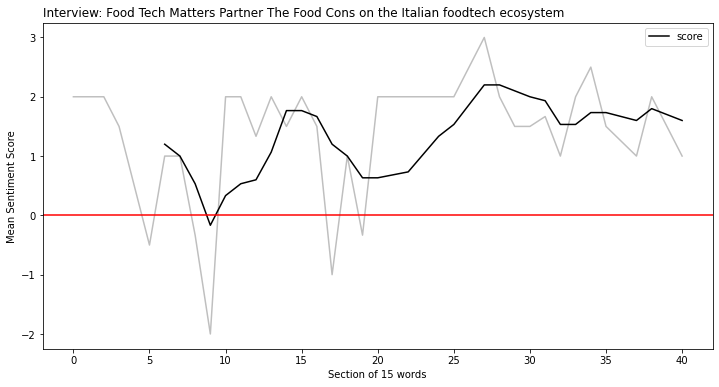

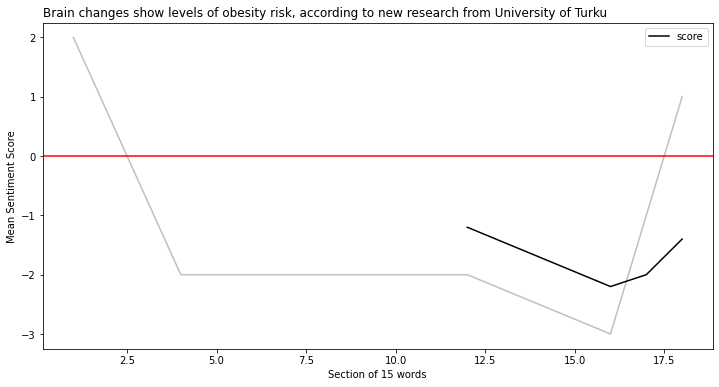

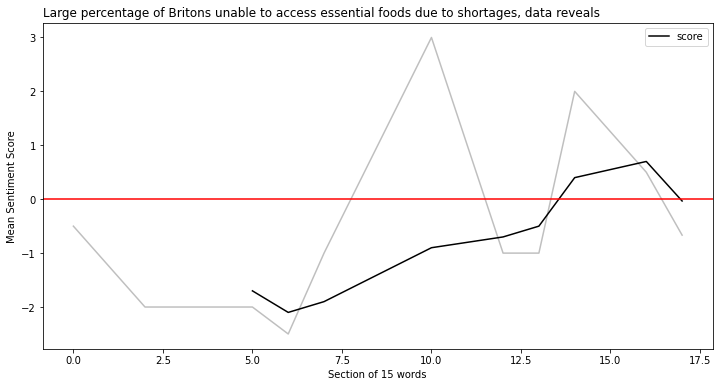

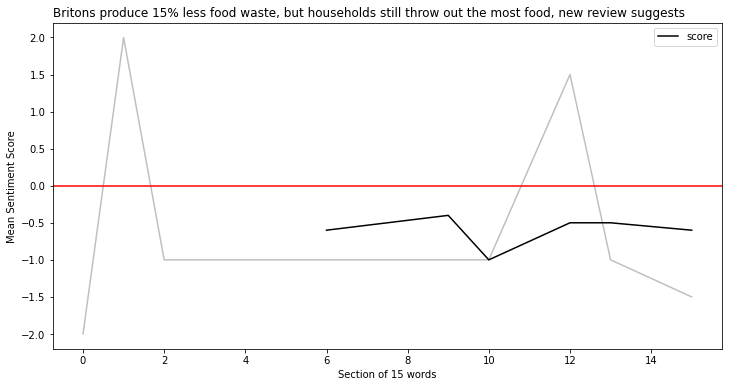

In [45]:
FMLnews('2021-06-01')